In [ ]:
from lightkurve import KeplerLightCurveFile
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import batman

lcf = KeplerLightCurveFile.from_archive('Kepler-8', quality_mask='hard', quarter=1)
lc = lcf.PDCSAP_FLUX.remove_nans().normalize()
lc.plot()

In [2]:
import astropy.units as u
from astropy.constants import G
teff = lcf.header()['TEFF']
logg = lcf.header()['LOGG']
feh = lcf.header()['FEH']
r= lcf.header()['RADIUS']*u.solRad

g = 10.**(logg)*(u.cm/u.second**2)
m = ((g*r**2)/G).to(u.solMass)

In [3]:
from PyAstronomy import pyasl
import astropy.units as u
nexa = pyasl.NasaExoplanetArchive()
planet = nexa.selectByPlanetName('kepler-8 b')

# Planet Period
per = planet['pl_orbper']

# Transit midpoint
t0 = planet['pl_tranmid'] - 2454833.0

In [4]:
rp_init = ((np.median(lc.flux) - np.min(lc.flux)) / np.median(lc.flux))**0.5
i_init = 90
d = (((per*u.day).to(u.second))**2 * G * m / (4*np.pi**2))**(1./3.)
a_init = (d.to(u.solRad)/r).value

In [5]:
from scipy.optimize import minimize
import emcee 
import corner 

params = batman.TransitParams()       #object to store transit parameters
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "quadratic"        #limb darkening model
params.u = [0.5230, 0.1218]           #limb darkening coefficients
params.rp = rp_init
params.a = a_init
params.inc = 90
params.t0 = t0
params.per = per

m = batman.TransitModel(params, np.asarray(lc.time, dtype=float))    
def liklihood(guess, y, e):
    params.rp = guess[0]
    params.a = guess[1]
    params.inc = guess[2]
    params.t0 = guess[3]
    params.per = guess[4]
    model = m.light_curve(params)
    return -0.5*(np.nansum((model - y)**2/(e**2)))

def prior(theta):
    if ((theta[0] < rp_init*1.5) & (theta[0] > rp_init*0.5) &
       (theta[4] > per*0.97) & (theta[4] < per*1.03) &
       (theta[1] > 1) & (theta[1] < 2000)):       
        return 0.0
    return -np.inf

def prob(theta, y, e):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + liklihood(theta, y, e)

nll = lambda *args: -liklihood(*args)
ndim, nwalkers = 5, 100


pos = [[rp_init, a_init, i_init, t0, per] + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, prob, args=(lc.flux, lc.flux_err))
sampler.run_mcmc(pos, 2000)
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))

In [6]:
rp_mcmc, a_mcmc, i_mcmc, t0_mcmc, per_mcmc = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
                                                 zip(*np.percentile(samples, [16, 50, 84],
                                                                axis=0)))

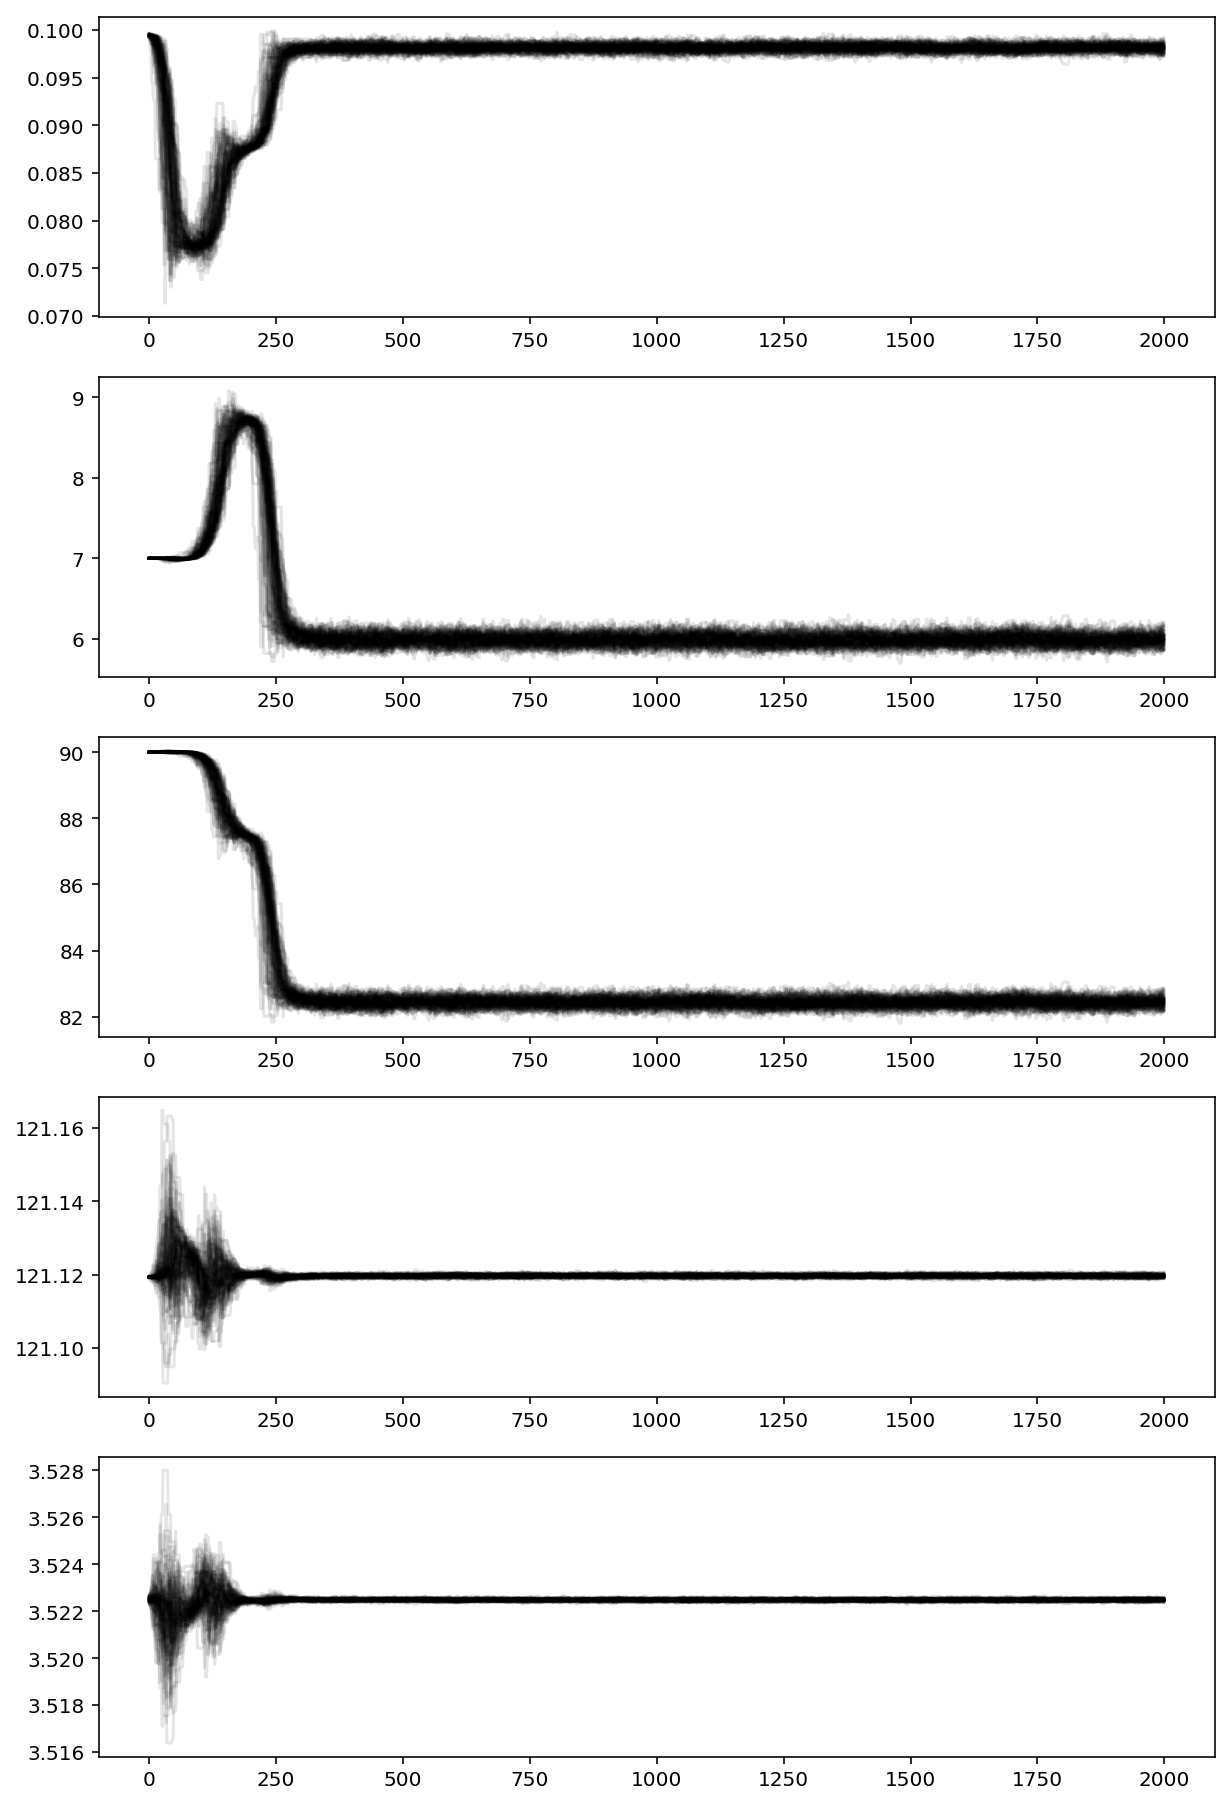

In [7]:
fig, axs = plt.subplots(5, figsize=(10, 16))
for i in range(5):
    _ = axs[i].plot(sampler.chain[:, :, i].T, alpha=0.1, color='k');

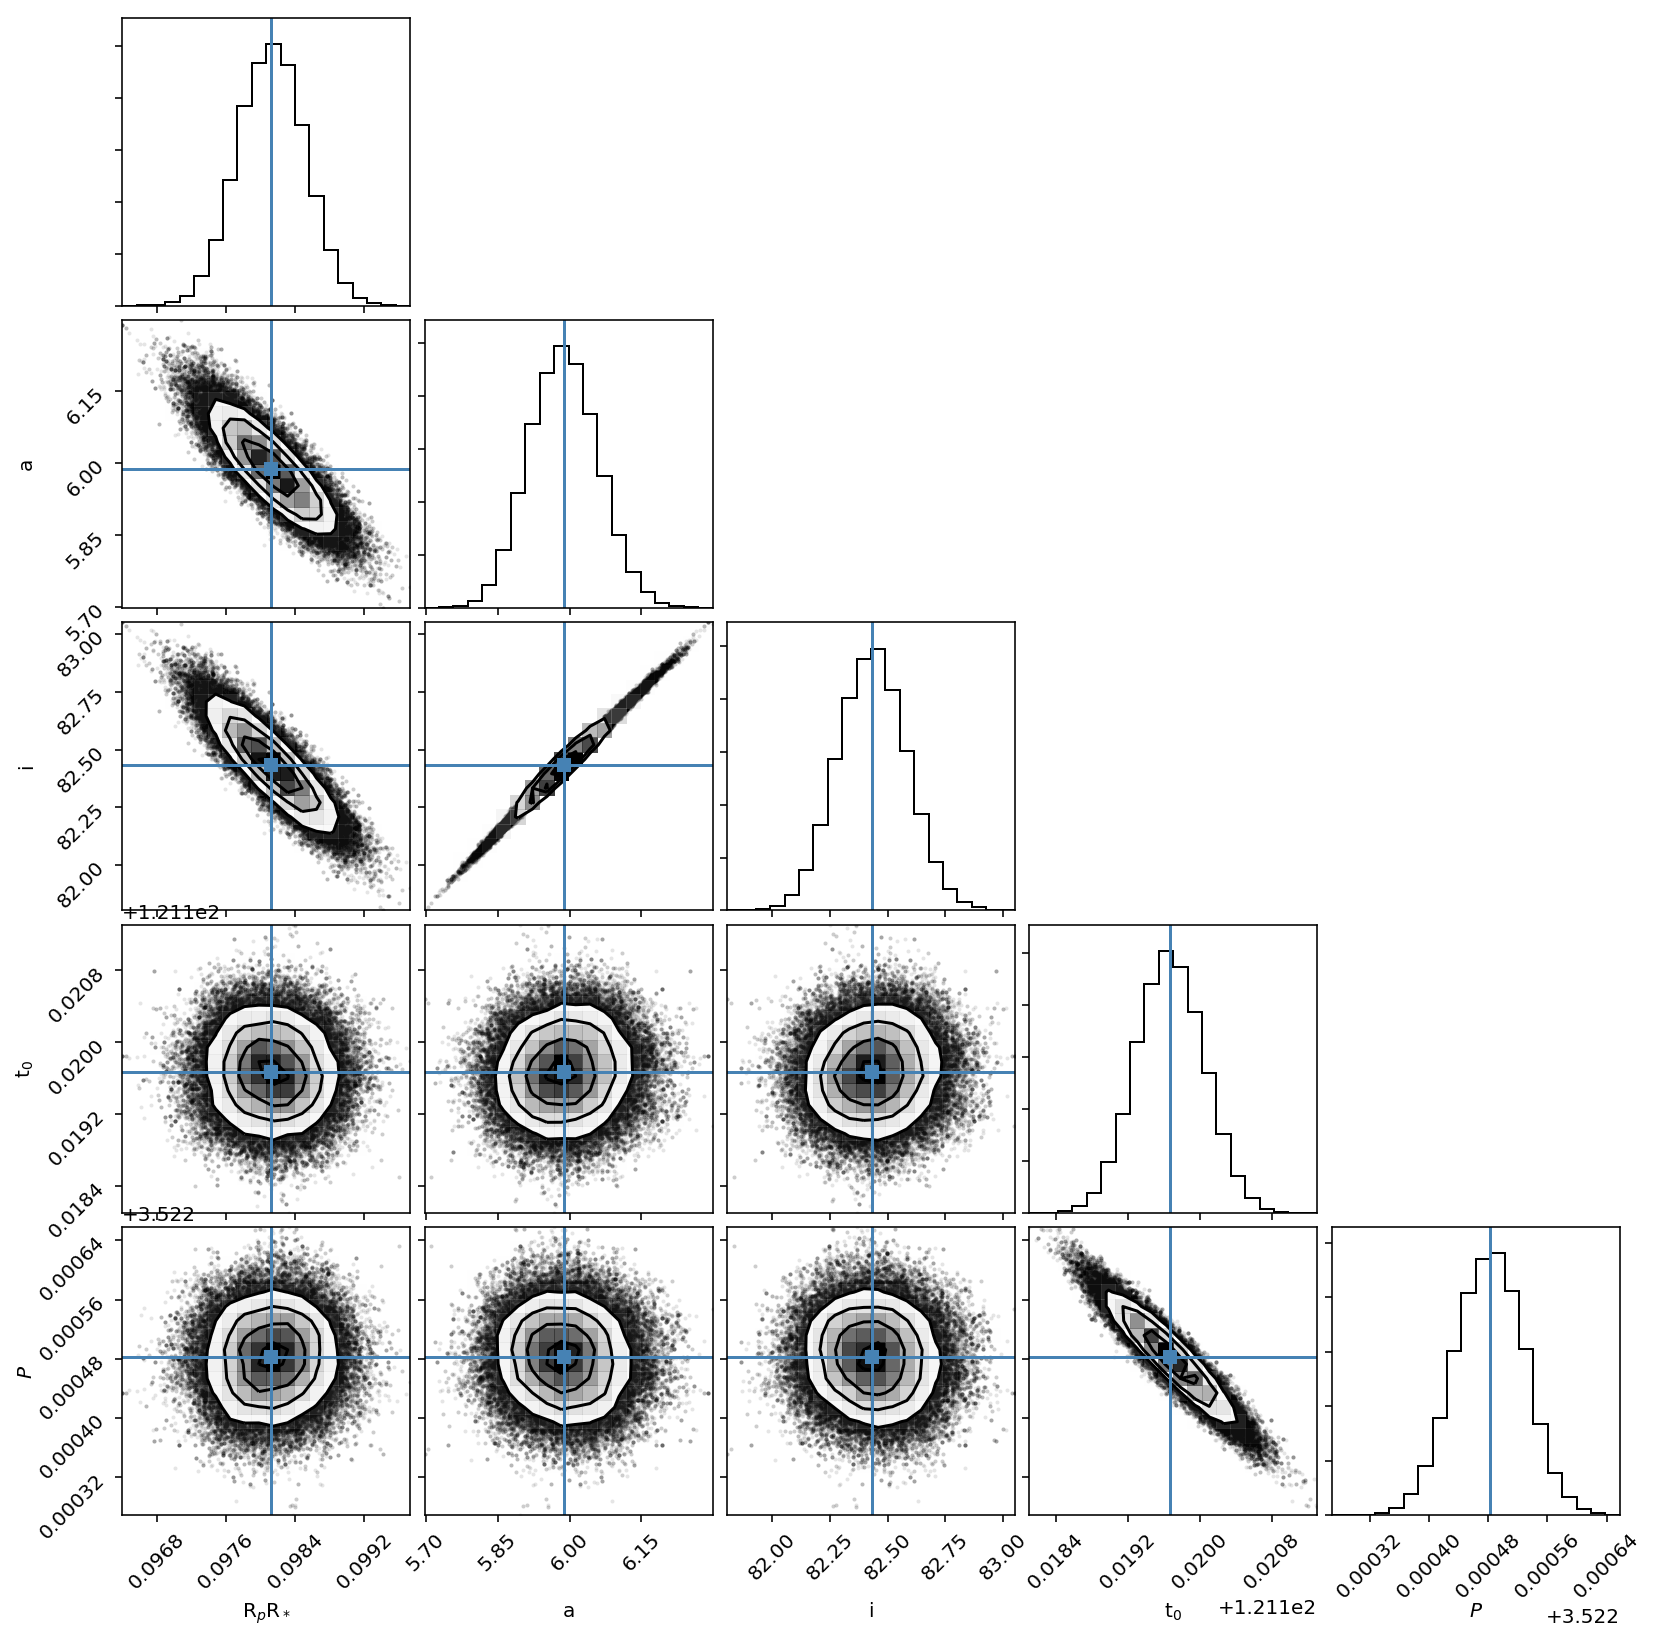

In [9]:
cornerplot = corner.corner(samples, labels=['R$_p$R$_*$', 'a', 'i', 't$_0$', '$P$'],
                           truths=[rp_mcmc[0], a_mcmc[0], i_mcmc[0], t0_mcmc[0], per_mcmc[0]])

In [13]:
params = batman.TransitParams()       #object to store transit parameters
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "quadratic"        #limb darkening model
params.u = [0.5230, 0.1218]           #limb darkening coefficients
params.rp = rp_mcmc[0]
params.a = a_mcmc[0]
params.inc = i_mcmc[0]
params.t0 = t0_mcmc[0]
params.per = per_mcmc[0]

m = batman.TransitModel(params, np.asarray(lc.time, dtype=float))    


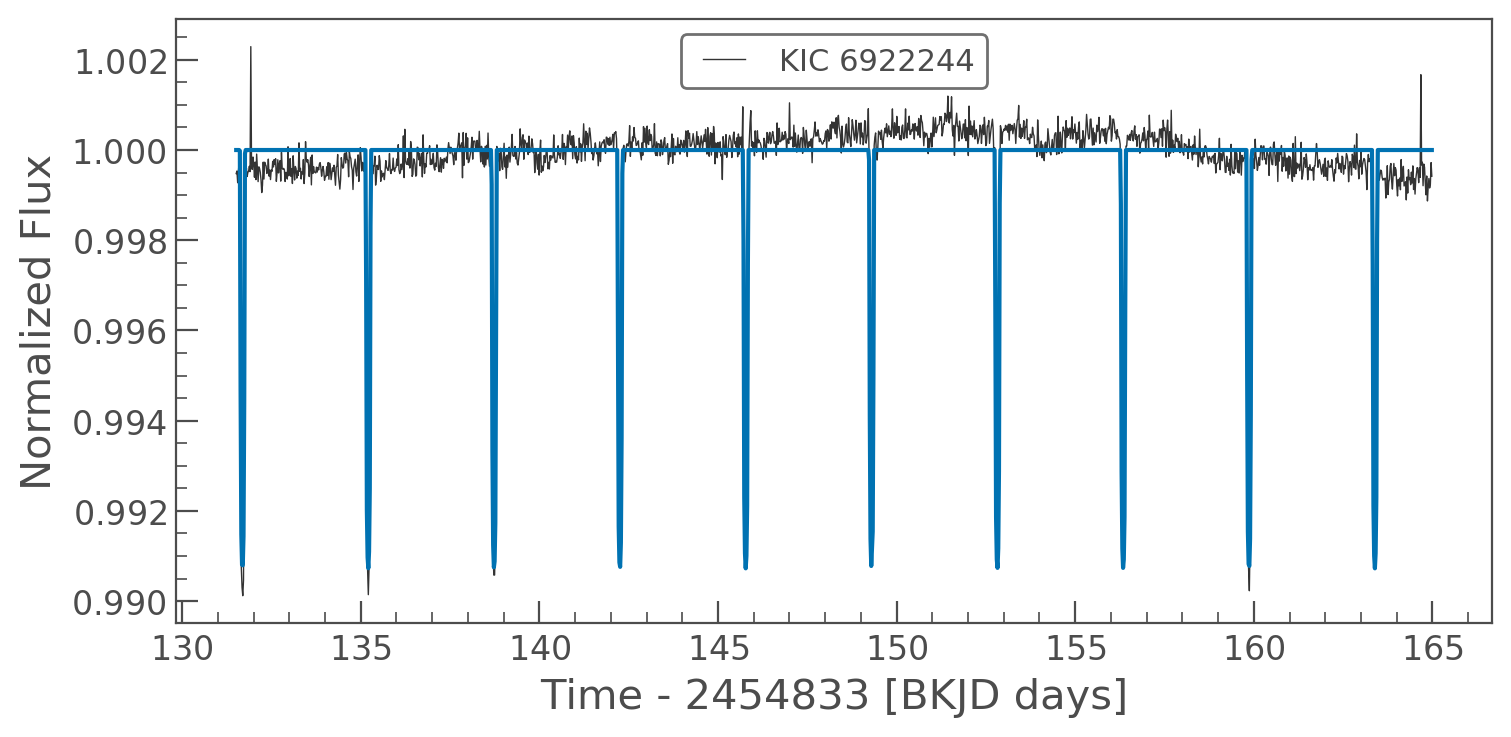

In [16]:
ax = lc.plot()
ax.plot(lc.time, m.light_curve(params))